# Preamble

In [1]:

import numpy as np
from lmfit import minimize, Parameters

from matplotlib import patheffects, rcParams, ticker, gridspec, pyplot as plt
from matplotlib.colors import to_rgb

import gc
from typing import Union

import gekim as gk
from gekim.utils.helpers import round_sig
from gekim.fields.bio.enzyme.inhib import irrev as ii


## General settings

In [2]:
# Variables for plot styling
points_lw = 0.5
dash_stroke = 2.5
border_lw = 0.8
sample_alpha = 0.2
sample_lw = 0.8
legend_fs = 8
tick_fs = 8
axis_fs = 10
single_col = 3.25 #in
double_col = 7.0 #in

# Set interactive backend
%matplotlib inline

# Set matplotlib parameters for plotting
rcParams.update({
    'font.size': 12,
    'figure.autolayout': False,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'axes.formatter.useoffset': False,
    'axes.formatter.limits': (-4, 5),
    'axes.axisbelow': False,
    'lines.linewidth': 1,
})

# Custom formatter for mpl tick labels
class CustomSciFormatter(ticker.ScalarFormatter):
    def __init__(self, low=-3, high=4, useMathText=True, sig_figs=3, force_sci=False, useOffset=False, **kwargs):
        super().__init__(useMathText=useMathText, **kwargs)
        self.low = low  # Lower exponent bound
        self.high = high  # Upper exponent bound
        self.sig_figs = sig_figs
        self.force_sci = force_sci
        self.set_useOffset(useOffset)
        
    def __call__(self, x, pos=None):
        if x == 0:
            return '0'
        exponent = int(np.floor(np.log10(abs(x))))
        if self.low <= exponent <= self.high and not self.force_sci:
            return f"{round_sig(x,sig_figs=self.sig_figs,autoformat=False)}"
        else:
            mantissa = x / (10 ** exponent)
            return f"{round_sig(mantissa,sig_figs=self.sig_figs,autoformat=False)}E{exponent:d}"



## General functions

In [3]:
def format_spines(fig: plt.Figure, zorder=1000000, lw=0.8) -> None:
    """Increases linewidth and zorder of axes spines"""
    for ax in fig.get_axes():
        for spine in ax.spines.values():
            spine.set_zorder(zorder)
            spine.set_linewidth(lw)

def fig_setup(fig):
    format_spines(fig)
    formatter = CustomSciFormatter(low=-2, high=2)
    for ax in fig.get_axes():
        ax.set_axisbelow(False)
        ax.yaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_formatter(formatter)
        ax.tick_params(axis='both', which='major', labelsize="small", pad=2, length=2.4, width=.6)
        ax.tick_params(axis='both', which='minor', length=1.6, width=.6)

def clear_fig(fig: plt.Figure) -> None:
    """Clear and garbage collect a matplotlib figure"""
    for ax in fig.get_axes():
        ax.clear()
    fig.clear()
    gc.collect()
    return


# Noncovalent vs covalent (Figure 1)

In [4]:
concI0,concE0 = 1000,1 # nM
kon     = 1e-5   # nM^-1s^-1
koff    = 1e-2   # s^-1
kinact  = 1e-4   # s^-1
kinactb = 0

Parm = 0.5
Pdisarm = 1-Parm
oom = 7 # us time scale for conformational changes
karm,kdisarm = gk.utils.helpers.rate_pair_from_P(oom,P_B=Parm)

schemes = {}

koff_app = koff*Pdisarm
kinact_app = kinact*Parm


schemes["2S"] = {
    "transitions": {
        "kon": {"k": kon, "source": ["E", "I"], "target": ["EI"]},
        "koff_app": {"k": koff, "source": ["EI"], "target": ["E", "I"]},
    },
    "species": {
        "I": {"y0": concI0, "label": r"I"},
        "E": {"y0": concE0, "label": r"E"},
        "EI": {"y0": 0, "label": r"E-I"},
    },
}

schemes["4S"] = {
    "transitions": {
        "kon": {"k": kon, "source": ["E", "I"], "target": ["E__I"]},
        "koff": {"k": koff, "source": ["E__I"], "target": ["E", "I"]},
        "karm": {"k": karm, "source": ["E__I"], "target": ["E_I"]},
        "kdisarm": {"k": kdisarm, "source": ["E_I"], "target": ["E__I"]},
        "kinact": {"k": kinact, "source": ["E_I"], "target": ["EI"]},
        "kinactb": {"k": kinactb, "source": ["EI"], "target": ["E_I"]},
    },
    "species": {
        "I": {"y0": concI0, "label": r"I"},
        "E": {"y0": concE0, "label": r"E"},
        "E__I": {"y0": 0, "label": r"E${\cdot}\!{\cdot}$I"},
        "E_I": {"y0": 0, "label": r"E${\cdot}$I"},
        "EI": {"y0": 0, "label": r"E-I"},
    },
}

schemes["4S_nc"] = {
    "transitions": {
        "kon": {"k": kon, "source": ["E", "I"], "target": ["E__I"]},
        "koff": {"k": koff, "source": ["E__I"], "target": ["E", "I"]},
        "karm": {"k": karm, "source": ["E__I"], "target": ["E_I"]},
        "kdisarm": {"k": kdisarm, "source": ["E_I"], "target": ["E__I"]},
    },
    "species": {
        "I": {"y0": concI0, "label": r"I"},
        "E": {"y0": concE0, "label": r"E"},
        "E__I": {"y0": 0, "label": r"E${\cdot}\!{\cdot}$I"},
        "E_I": {"y0": 0, "label": r"E${\cdot}$I"},
    },
}

schemes = gk.utils.plotting.assign_colors_to_species(schemes,saturation_range=(0.5,0.8),lightness_range=(0.4,0.4),offset=0.0,method="GR",overwrite_existing=False)

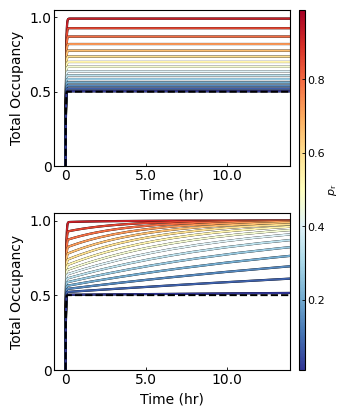

In [ ]:

scalar_arr = np.linspace(0.01, 0.99, 15)
scalar_arr[-1] = 0.99

# Initialize figure
cmap = plt.cm.RdYlBu.reversed()
fig = plt.figure(figsize=(single_col, 4))
gs = gridspec.GridSpec(2, 2, figure=fig,
                       width_ratios=[1, 0.025],
                       hspace=0.3, wspace=0.075, top=0.99, bottom=0.09, left=0.13, right=0.90)
axs = np.array([[fig.add_subplot(gs[r, c]) for c in range(1)] for r in range(2)]).flatten()
cbax = fig.add_subplot(gs[:, 1])
fig_setup(fig)

t_span = (0, 5e4-1)

for i, Parm in enumerate(scalar_arr):
    color = cmap(i / len(scalar_arr))
    karm,kdisarm = gk.utils.helpers.rate_pair_from_P(oom,P_B=Parm)
   
    # First panel: timecourse fits for irrev
    schemes["4S"]["transitions"]["karm"]["k"] = karm
    schemes["4S"]["transitions"]["kdisarm"]["k"] = kdisarm
    
    system, tr_fit = ii.Experiments.time_response(schemes["4S"], sim_kwargs={"t_span": t_span}, fit_occ_kwargs={"verbosity": 1})
    all_bound = system.sum_species_simout(whitelist=["E__I","E_I", "EI"])
    line, = axs[1].plot(system.simout["t"]/3600, all_bound,  ls="-", lw=1.4, color=color, zorder=100-i)
    line.set_path_effects([patheffects.withStroke(linewidth=1.6, foreground='black')])

    # Second panel: timecourse fits for rev
    schemes["4S_nc"]["transitions"]["karm"]["k"] = karm
    schemes["4S_nc"]["transitions"]["kdisarm"]["k"] = kdisarm

    system = gk.System(schemes["4S_nc"],quiet=True)
    system.simulator = gk.simulators.ODESolver(system)
    system.simulator.simulate(t_span=t_span)
    all_bound = system.sum_species_simout(whitelist=["E__I","E_I"])
    line, = axs[0].plot(system.simout["t"]/3600, all_bound, ls="-", lw=1.4, color=color, zorder=100-i)
    line.set_path_effects([patheffects.withStroke(linewidth=1.6, foreground='black')])

two_state = gk.System(schemes["2S"],quiet=True)
two_state.simulator = gk.simulators.ODESolver(two_state)
two_state.simulator.simulate(t_span=t_span)

axs[0].plot(two_state.simout["t"]/3600, two_state.species["EI"].simout["y"], ls="--", lw=1.4, color="black",label=None, zorder=100)
axs[1].plot(two_state.simout["t"]/3600, two_state.species["EI"].simout["y"], ls="--", lw=1.4, color="black",label=None, zorder=100)

axs[0].set_xlabel(r'Time (hr)', fontsize=axis_fs)
axs[0].set_ylabel(r'Total Occupancy', fontsize=axis_fs)

axs[1].set_xlabel(r'Time (hr)', fontsize=axis_fs)
axs[1].set_ylabel(r'Total Occupancy', fontsize=axis_fs)

axs[0].set_xlim(axs[0].get_xlim()[0], t_span[-1]/3600)
axs[0].set_xticks([0,5.0,10.0])
axs[0].set_ylim(0, 1.05)
axs[0].set_yticks([0,0.5,1])

axs[1].set_xlim(axs[0].get_xlim()[0], t_span[-1]/3600)
axs[1].set_xticks([0,5.0,10.0])
axs[1].set_ylim(0, 1.05)
axs[1].set_yticks([0,0.5,1])

# Create a colorbar axis on the right side
norm = plt.Normalize(0.01, 0.99)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cbax)
cbar.set_label(r'$p_{\text{r}}$', fontsize=legend_fs, labelpad=1)
cbar.ax.tick_params(labelsize=tick_fs)

plt.show()
clear_fig(fig)


# Residence times (Figure 2)

In [7]:
concI0,concE0 = 1000,1 # nM
kon     = 1e-5   # nM^-1s^-1
koff    = 1e-2   # s^-1
kinact  = 1e-4   # s^-1
kinactb = 0

Parm = 0.5
Pdisarm = 1-Parm
oom = 7 # us time scale for conformational changes
karm,kdisarm = gk.utils.helpers.rate_pair_from_P(oom,P_B=Parm)

schemes = {}

koff_app = koff*Pdisarm
kinact_app = kinact*Parm

schemes["4S_nc_decay"] = {
    "transitions": {
        "kon": {"k": 0, "source": ["E", "I"], "target": ["E__I"]},
        "koff": {"k": koff, "source": ["E__I"], "target": ["E", "I"]},
        "karm": {"k": karm, "source": ["E__I"], "target": ["E_I"]},
        "kdisarm": {"k": kdisarm, "source": ["E_I"], "target": ["E__I"]},
    },
    "species": {
        "I": {"y0": concI0-concE0, "label": r"I"},
        "E": {"y0": 0, "label": r"E"},
        "E__I": {"y0": 0, "label": r"E${\cdot}\!{\cdot}$I"},
        "E_I": {"y0": concE0, "label": r"E${\cdot}$I"},
    },
}

schemes = gk.utils.plotting.assign_colors_to_species(schemes,saturation_range=(0.5,0.8),lightness_range=(0.4,0.4),offset=0.0,method="GR",overwrite_existing=False)

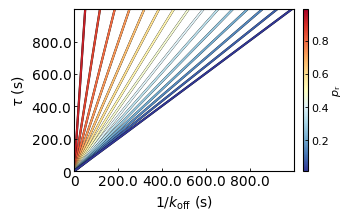

In [ ]:
def calc_residence_time(t,all_bound,conc0):
    """
    Calc survival time of bound state when kon = 0. Gets halflife and then scales it to residence time of first order decay
    """
    # Find the index of the time at which LP reaches 0.5
    try:
        time_index = np.where(all_bound <= (conc0/2))[0][0]
    except IndexError:
        time_index=-1
    # The time at which EI reaches 0.5 is at the corresponding index in the time array
    time_to_reach_half = t[time_index]
    return time_to_reach_half/np.log(2)

scalar_arr = np.linspace(0.01, 0.95, 15)

# Initialize figure
cmap = plt.cm.RdYlBu.reversed()
fig = plt.figure(figsize=(single_col, 2))
gs = gridspec.GridSpec(1, 2, figure=fig,
                       width_ratios=[1, 0.025],
                       hspace=0.3, wspace=0.075, top=0.99, bottom=0.18, left=0.18, right=0.90)
axs = fig.add_subplot(gs[0, 0])
cbax = fig.add_subplot(gs[:, 1])
fig_setup(fig)

t_eval = np.linspace(0, int(1e6), int(1e6))
koffs = np.geomspace(koff/10, koff*10, 10)
koffs[-1] = koff*1000

residence_times = np.zeros((len(koffs),len(scalar_arr)))
residence_times_analytical = np.zeros((len(koffs),len(scalar_arr)))

for i, Parm in enumerate(scalar_arr):
    color = cmap(i / len(scalar_arr))
    karm,kdisarm = gk.utils.helpers.rate_pair_from_P(oom,P_B=Parm)

    # Second panel: timecourse fits for rev
    schemes["4S_nc_decay"]["transitions"]["karm"]["k"] = karm
    schemes["4S_nc_decay"]["transitions"]["kdisarm"]["k"] = kdisarm

    for koff_test in koffs:
        schemes["4S_nc_decay"]["transitions"]["koff"]["k"] = koff_test
        
        system = gk.System(schemes["4S_nc_decay"],quiet=True)
        system.simulator = gk.simulators.ODESolver(system)
        system.simulator.simulate(t_eval=t_eval)
        all_bound = system.sum_species_simout(whitelist=["E__I","E_I"])
        residence_time = calc_residence_time(system.simout["t"],all_bound,concE0)
        residence_times[koffs==koff_test,i] = residence_time
        residence_times_analytical[koffs==koff_test,i] = 1/(koff_test*(1-Parm))
    
    line,  = axs.plot(1/(koffs),residence_times[:,i], ls="-", lw=1.4, color=color, zorder = 0-i)
    line.set_path_effects([patheffects.withStroke(linewidth=1.6, foreground='black')])

axs.set_xlabel(r'1/$k_\text{off}$ (s)', fontsize=axis_fs)
axs.set_ylabel(r'$\tau$ (s)', fontsize=axis_fs)

axs.set_xlim(0, 1e3-1)
axs.set_ylim(0, 1e3-1)

# Create a colorbar axis on the right side
norm = plt.Normalize(0.01, 0.99)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cbax)
cbar.set_label(r'$p_{\text{r}}$', fontsize=legend_fs, labelpad=1.5)
cbar.ax.tick_params(labelsize=tick_fs)

plt.show()
clear_fig(fig)


# Dose-rate (Figure 3)

In [10]:
concI0,concE0 = 1000,1 # nM
kon     = 1e-5   # nM^-1s^-1
koff    = 1e-2   # s^-1
kinact  = 1e-4   # s^-1

Parm = 0.5
Pdisarm = 1-Parm

schemes = {}

koff_app = koff*Pdisarm
kinact_app = kinact*Parm
schemes["3SR"] = {
    "transitions": {
        "kon": {"k": kon, "source": ["E", "I"], "target": ["E___I"]},
        "koff_app": {"k": koff_app, "source": ["E___I"], "target": ["E", "I"]},
        "kinact_app": {"k": kinact_app, "source": ["E___I"], "target": ["EI"]},
    },
    "species": {
        "I": {"y0": concI0, "label": r"I"},
        "E": {"y0": concE0, "label": r"E"},
        "E___I": {"y0": 0, "label": r"E${\cdot}\!{\cdot}\!{\cdot}$I"},
        "EI": {"y0": 0, "label": r"E-I"},
    },
}

schemes = gk.utils.plotting.assign_colors_to_species(schemes,saturation_range=(0.5,0.8),lightness_range=(0.4,0.4),offset=0.0,method="GR",overwrite_existing=False)

Bad fit detected: 
	Parameter kobs is at or near its lower bound: 0.

Name       Value      Min      Max   Stderr     Vary     Expr Brute_Step
Etot           1        0      inf        0    False     None     None
concI0        10        0      inf        0    False     None     None
kns            0        0      inf        0    False     None     None
kobs    1.724e-09        0      inf 2.746e-11     True     None     None
uplim          1        0      inf        0    False     None     None


Bad fit detected: 
	Parameter kobs is at or near its lower bound: 0.

Name       Value      Min      Max   Stderr     Vary     Expr Brute_Step
Etot           1        0      inf        0    False     None     None
concI0        10        0      inf        0    False     None     None
kns            0        0      inf        0    False     None     None
kobs    1.834e-09        0      inf 2.94e-11     True     None     None
uplim          1        0      inf        0    False     None     None

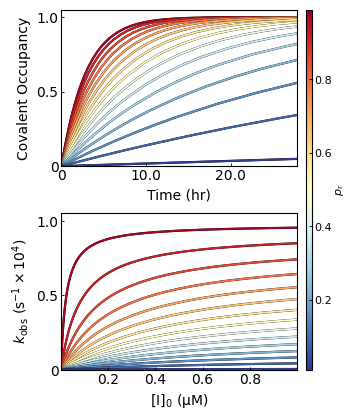

In [ ]:

scalar_arr = np.linspace(0.01, 1, 15)
scalar_arr[-1] = 0.99

# Initialize figure
cmap = plt.cm.RdYlBu.reversed()
fig = plt.figure(figsize=(single_col, 4))
gs = gridspec.GridSpec(2, 2, figure=fig,
                       width_ratios=[1, 0.025],
                       hspace=0.3, wspace=0.075, top=0.99, bottom=0.09, left=0.13, right=0.90)
axs = np.array([[fig.add_subplot(gs[r, c]) for c in range(1)] for r in range(2)]).flatten()
cbax = fig.add_subplot(gs[:, 1])
fig_setup(fig)

scheme = schemes["3SR"]

concI0_arr = np.geomspace(2, 1e3-1, 100)
t_span = (0, 1e5-1)

for i, Parm in enumerate(scalar_arr):
    scheme["transitions"]["koff_app"]["k"] = koff * (1 - Parm)
    scheme["transitions"]["kinact_app"]["k"] = kinact * Parm

    color = cmap(Parm)

    # First panel: timecourse fits
    system, tr_fit = ii.Experiments.time_response(schemes["3SR"], sim_kwargs={"t_span": t_span}, fit_occ_kwargs={"verbosity": 1})
    line, = axs[0].plot(tr_fit.userdata["x"]/3600, tr_fit.best_fit, ls="-", label=r"$\mathcal{P}_{\text{arm}}=$" + f" {round_sig(Parm, 2)}", color=color, lw=1.4, zorder = 0-i)
    line.set_path_effects([patheffects.withStroke(linewidth=1.6, foreground='black')])

    # Second panel: dose-response fits
    dr_fit = ii.Experiments.dose_rate(schemes["3SR"], concI0_arr, num_cores=8, fit_kobs_kwargs={"verbosity": 1})
    line, = axs[1].plot(dr_fit.userdata["x"]/1000, dr_fit.best_fit*1e4, ls="-", label=r"$\mathcal{P}_{\text{arm}}=$" + f" {round_sig(Parm, 2)}", color=color, lw=1.4, zorder = 0-i)
    line.set_path_effects([patheffects.withStroke(linewidth=1.6, foreground='black')])

    print(f"Parm: {Parm}, KI: {gk.fields.bio.enzyme.inhib.irrev.Params.KI(kon,koff * (1 - Parm),kinact * Parm)}")


axs[0].set_xlabel(r'Time (hr)', fontsize=axis_fs)
axs[0].set_ylabel(r'Covalent Occupancy', fontsize=axis_fs)

axs[1].set_xlabel(r'[I]$_0$ (µM)', fontsize=axis_fs)
axs[1].set_ylabel(r'$k_{\text{obs}}$ (s$^{-1} \times 10^4$)', fontsize=axis_fs)

axs[0].set_xlim(t_span[0], t_span[-1]/3600)
axs[0].set_xticks([0,10.0,20.0])
axs[0].set_ylim(0, 1.05)
axs[0].set_yticks([0,0.5,1])

axs[1].set_xlim((concI0_arr[0]*1.01)/1000, concI0_arr[-1]/1000)
axs[1].set_xticks([0.2,0.4,0.6,0.8])
axs[1].set_ylim(0, axs[1].get_ylim()[1]*1.05)
axs[1].set_yticks([0,0.5,1])

# Create a colorbar axis on the right side
norm = plt.Normalize(0.01, 0.99)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cbax)
cbar.set_label(r'$p_{\text{r}}$', fontsize=legend_fs, labelpad=1)
cbar.ax.tick_params(labelsize=tick_fs)

plt.show()
clear_fig(fig)


# Dose-response (Figures 4 and 5)

In [ ]:
def make_system(kon, koff, kinact, Parm, concI0: Union[float, np.ndarray], 
                concE0: Union[float, np.ndarray], quiet=True) -> gk.System:
    """Configure the kinetic scheme"""
    Pdisarm = 1 - Parm
    koff_app = koff*Pdisarm
    kinact_app = kinact*Parm
    scheme = {
        "transitions": {
            "kon": {"k": kon, "source": ["E", "I"], "target": ["E___I"]},
            "koff_app": {"k": koff_app, "source": ["E___I"], "target": ["E", "I"]},
            "kinact_app": {"k": kinact_app, "source": ["E___I"], "target": ["EI"]},
        },
        "species": {
            "I": {"y0": concI0, "label": r"I"},
            "E": {"y0": concE0, "label": r"E"},
            "E___I": {"y0": 0, "label": r"E${\cdot}\!{\cdot}\!{\cdot}$I"},
            "EI": {"y0": 0, "label": r"E-I"},
        },
    }

    scheme = gk.utils.plotting.assign_colors_to_species(scheme,saturation_range=(0.5,0.8),lightness_range=(0.4,0.4),offset=0.0,method="GR",overwrite_existing=False)
    system = gk.System(scheme, quiet=quiet)
    return system



In [15]:
concI0,concE0 = 10000,1 # nM
kon     = 1e-5   # nM^-1s^-1
koff    = 1e-2   # s^-1
kinact  = 1e-4   # s^-1

Parm = 0.5
Pdisarm = 1-Parm
koff_app = koff*Pdisarm
kinact_app = kinact*Parm


## Analytical vs numerical (Figure 4)

Case 1: kon = 5.00e-07, koff_app = 5.00e-03, kinact_app = 5.00e-03, n = 1.47
Case 2: kon = 1.00e-05, koff_app = 5.00e-03, kinact_app = 5.00e-05, n = 1.03
Case 3: kon = 5.00e-06, koff_app = 5.00e-03, kinact_app = 2.50e-05, n = 1.11


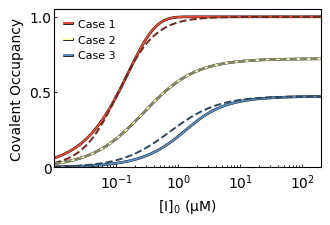

In [ ]:

def CO_Hill(concI0, t_dr, kon, koff_app, kinact_app, n):
    numerator = 1 - np.exp(-kinact_app * t_dr)
    eta = np.log((1 + np.exp(-kinact_app * t_dr)) / 2)
    KI_app = ( koff_app + kinact_app ) / kon
    EC50 = ( -KI_app * eta ) / ( kinact_app * t_dr + eta )
    denominator = 1 + (EC50 / concI0) ** n
    CO = numerator / denominator
    return CO

def fit_CO_Hill(concI, CO, t_dr, kon, koff_app, kinact_app):
    def residues(params, x, data):
        n = params['n'].value
        return CO_Hill(x, t_dr, kon, koff_app, kinact_app, n) - data
    params = Parameters()
    params.add('n', value=1.0, min=0.0)  # n: cooperativity exponent
    fit = minimize(residues, params, args=(concI, CO))
    return fit
    

scalar_arr = np.linspace(0.2, 1.8, 15)
t_dr = (-1*np.log(1-0.90) / (kinact * scalar_arr[-1] * Parm))
concI0 = np.geomspace(10, 2e5, 100)
response_sp = ["EI"]

# Initialize figure
cmap = plt.cm.RdYlBu.reversed()
fig = plt.figure(figsize=(single_col, 2))
gs = gridspec.GridSpec(1, 1, figure=fig, top=0.99, bottom=0.2, left=0.13, right=0.95)
axs = fig.add_subplot(gs[0, 0])
fig_setup(fig)
axs.tick_params(axis='x', which='major', pad=4) # extra padding for exponent in x-axis

# Simulation
for case in range(3):
    system = make_system(kon, koff, kinact, Parm, concI0, concE0, quiet=True)
    if case == 0:
        color = cmap(0.85)
        system.transitions["kon"].k = kon * 0.05
        system.transitions["koff_app"].k = koff * (1-Parm) 
        system.transitions["kinact_app"].k = kinact * Parm * 100
    if case == 1:
        color = cmap(0.5)
        
    if case == 2:
        color = cmap(0.15)
        system.species["E"].y0 = concE0 * 1000
        system.transitions["kon"].k = kon * 0.5
        system.transitions["koff_app"].k = koff * (1-Parm) 
        system.transitions["kinact_app"].k = kinact * Parm * 0.5
        
        
        
    system.simulator = gk.simulators.ODESolver(system)
    system.simulator.simulate(t_span=(0,t_dr), method="LSODA")

    response_sim = system.sum_species_simout(whitelist=response_sp)
    response_sim = np.array([simout[-1] for simout in response_sim])/system.species["E"].y0 
    
    fit = fit_CO_Hill(concI0, response_sim, t_dr, system.transitions["kon"].k, system.transitions["koff_app"].k, system.transitions["kinact_app"].k)
    n_fit = fit.params['n'].value
    CO_fit = CO_Hill(concI0, t_dr, system.transitions["kon"].k, system.transitions["koff_app"].k, system.transitions["kinact_app"].k, n_fit)
    
    line, = axs.plot(concI0/1000, response_sim, label=f"Case {case+1}", ls='-', color=color, lw=1.4, zorder = 0-i)
    line.set_path_effects([patheffects.withStroke(linewidth=1.9, foreground='black')])
    
    rgb = to_rgb(color)
    darker_color = tuple(c * 0.5 for c in rgb)
    line, = axs.plot(concI0/1000, CO_fit,label=None, ls='--',color=darker_color, lw=1.4, zorder = 0-i, dash_joinstyle="miter")
    
    print(f"Case {case+1}: kon = {system.transitions['kon'].k:.2e}, koff_app = {system.transitions['koff_app'].k:.2e}, kinact_app = {system.transitions['kinact_app'].k:.2e}, n = {n_fit:.2f}")


axs.set_xscale("log")
axs.set_ylim(0, 1.05)
axs.set_xlim(concI0[0]/1000*1.01, concI0[-1]/1000)
axs.set_xlabel(r'[I]$_0$ (µM)', fontsize=axis_fs)
axs.set_ylabel(r'Covalent Occupancy', fontsize=axis_fs)
axs.set_yticks([0,0.5,1])  

leg = axs.legend(handlelength=0.7,frameon=False,fontsize=legend_fs,handletextpad=0.5,loc="upper left")

plt.show()
clear_fig(fig)

## Numerical comparisons (Figure 5)

   scale     koff (1/s)   kinact (1/s)           Parm
    0.20        2.0e-03        2.0e-05          0.100
    0.31        3.1e-03        3.1e-05          0.157
    0.43        4.3e-03        4.3e-05          0.214
    0.54        5.4e-03        5.4e-05          0.271
    0.66        6.6e-03        6.6e-05          0.329
    0.77        7.7e-03        7.7e-05          0.386
    0.89        8.9e-03        8.9e-05          0.443
    1.00        1.0e-02        1.0e-04          0.500
    1.11        1.1e-02        1.1e-04          0.557
    1.23        1.2e-02        1.2e-04          0.614
    1.34        1.3e-02        1.3e-04          0.671
    1.46        1.5e-02        1.5e-04          0.729
    1.57        1.6e-02        1.6e-04          0.786
    1.69        1.7e-02        1.7e-04          0.843
    1.80        1.8e-02        1.8e-04          0.900
Simulating with t_dr = 2558 seconds, 0.7 hours
Simulating with t_dr = 25584 seconds, 7.1 hours
Simulating with t_dr = 255843 seconds, 71

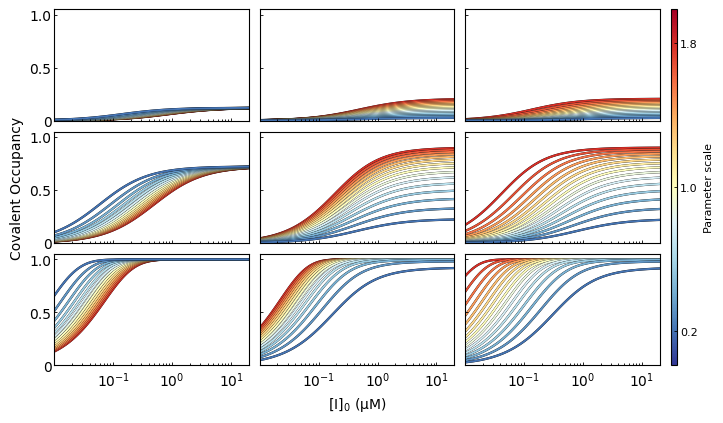

In [ ]:

scalar_arr = np.linspace(0.2, 1.8, 15)

t_dr = (-1*np.log(1-0.90) / (kinact * scalar_arr[-1] * Parm))
t_dr_list = [t_dr/10, t_dr, t_dr*10]

concI0 = np.geomspace(10, 2e4, 100)
response_sp = ["EI"]


# print info
header = "{:>8} {:>14} {:>14} {:>14}".format('scale','koff (1/s)','kinact (1/s)','Parm')
print(header)
for s in scalar_arr:
    print("{:8.2f} {:14.1e} {:14.1e} {:14.3f}".format(s, s*koff, s*kinact, s*Parm))

# Initialize figure
cmap = plt.cm.RdYlBu.reversed()
fig = plt.figure(figsize=(7, 4))
gs = gridspec.GridSpec(3, 4, figure=fig,
                       width_ratios=[1, 1, 1, 0.035],
                       hspace=0.1, wspace=0.075, top=0.99, bottom=0.1, left=0.06, right=0.95)
axs = np.array([[fig.add_subplot(gs[r, c]) for c in range(3)] for r in range(3)])
cbax = fig.add_subplot(gs[:, 3])
fig_setup(fig)
for ax in axs.flatten():
    ax.tick_params(axis='x', which='major', pad=4) # extra padding for exponent in x-axis

for row, t_dr in enumerate(t_dr_list):
    print(f"Simulating with t_dr = {t_dr:.0f} seconds, {t_dr/3600:.1f} hours")
    for col in range(3):
        for i, scalar in enumerate(scalar_arr):
            system = make_system(kon, koff, kinact, Parm, concI0, concE0, quiet=True)
            if col == 0:
                system.transitions["koff_app"].k = koff * scalar * (1-Parm)

            if col == 1:
                system.transitions["kinact_app"].k = kinact * scalar * Parm

            if col == 2:
                Parm_new = scalar * Parm
                system.transitions["koff_app"].k = koff * (1-Parm_new)
                system.transitions["kinact_app"].k = kinact * Parm_new

            
            system.simulator = gk.simulators.ODESolver(system)
            system.simulator.simulate(t_span=(0,t_dr), method="LSODA")

            response_sim = system.sum_species_simout(whitelist=response_sp)
            response_sim = np.array([simout[-1] for simout in response_sim])/concE0 
    
            color = cmap(scalar/2)
            line, = axs[row,col].plot(concI0/1000,response_sim,label=None,ls='-',color=color, lw=1.4, zorder = 0-i)
            line.set_path_effects([patheffects.withStroke(linewidth=1.6, foreground='black')])

        ax = axs[row,col]
        ax.set_xscale("log")
        ax.set_ylim(0, 1.05)
        ax.set_xlim(concI0[0]/1000*1.01, concI0[-1]/1000)
        if row == 2:
            if col == 1:
                ax.set_xlabel(r'[I]$_0$ (µM)', fontsize=axis_fs)
        else:
            ax.set_xticklabels([])
        if col == 0:
            ax.set_yticks([0,0.5,1])  
            if row == 1:
                ax.set_ylabel(r"Covalent Occupancy",fontsize=axis_fs)     
        else: 
            ax.set_yticklabels([])     

# Create a colorbar axis on the right side

norm = plt.Normalize(0.01, 1.99)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cbax)
cbar.set_label(r'Parameter scale', fontsize=legend_fs)
cbar.ax.tick_params(labelsize=tick_fs)
cbar.ax.set_yticks([0.2,1,1.8])

# fig.savefig('./figures/DResp_big.pdf', format='pdf', bbox_inches=None, dpi=600)
plt.show()
clear_fig(fig)